<a href="https://colab.research.google.com/github/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

First, set up the required Python modules and perform some general configuration.

(This part of the code follows the [CNN notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_cnn.ipynb) that you should already be familiar with.)

Install the required Python packages using [pip](https://en.wikipedia.org/wiki/Pip):

* [`transformers`](https://huggingface.co/docs/transformers/index) is a popular deep learning package
* [`datasets`](https://huggingface.co/docs/datasets/) provides support for loading, creating, and manipulating datasets
* [`accelerate`](https://pypi.org/project/accelerate/) is a wrapper we need to install in order to train torch models using a transformers trainer

Both `transformers` and `datasets` are used extensively on this course.

In [1]:
!pip3 install -q transformers datasets accelerate

(Above, the `!` at the start of the line tells the notebook to run the line as an operating system command rather than Python code, and the `-q` argument to `pip` runs the command in "quiet" mode, with less output.)

We'll also use the [`pprint`](https://docs.python.org/3/library/pprint.html) ("pretty-print") module to format output more readably below. The only difference to just using `print` is that some data structures will be easier to read and interpret.

In [2]:
from pprint import PrettyPrinter

pprint = PrettyPrinter(compact=True).pprint

Finally, we will reduce logging output. The `transformers` library by default produces fairly verbose logging. Commenting out the following code will enable low-priority output (`INFO` logging level and below).

In [3]:
import logging

logging.disable(logging.INFO)

---

# Download and prepare data

We will again use the `datasets` library function [`load_dataset`](https://huggingface.co/docs/datasets/master/en/package_reference/loading_methods#datasets.load_dataset) to load a dataset for our experiments.

In [4]:
import datasets


dataset = datasets.load_dataset("imdb")

Let's see what the dataset contains:

In [5]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


and print out an example:

In [6]:
pprint(dataset["train"][0])

{'label': 0,
 'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the '
         'controversy that surrounded it when it was first released in 1967. I '
         'also heard that at first it was seized by U.S. customs if it ever '
         'tried to enter this country, therefore being a fan of films '
         'considered "controversial" I really had to see this for myself.<br '
         '/><br />The plot is centered around a young Swedish drama student '
         'named Lena who wants to learn everything she can about life. In '
         'particular she wants to focus her attentions to making some sort of '
         'documentary on what the average Swede thought about certain '
         'political issues such as the Vietnam War and race issues in the '
         'United States. In between asking politicians and ordinary denizens '
         'of Stockholm about their opinions on politics, she has sex with her '
         'drama teacher, classmates, and married men.<br

---

# Tokenize and vectorize data

(This part of the code follows the [CNN notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_cnn.ipynb) that you should already be familiar with.)

To tokenize and vectorize the texts of our dataset, we will again use previously created tokenizers through the simple [`AutoTokenizer`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer) class.

The [`AutoTokenizer.from_pretrained`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer.from_pretrained) function can load the tokenizer associated with any of the large number of models found in the [Hugging Face models repository](https://huggingface.co/models). Here, our texts are in English, and we'll load the tokenizer for the [`bert-base-cased`](https://huggingface.co/bert-base-cased) model.

(**Note**: we're not actually using the BERT model here, just its tokenizer.)

In [7]:
import transformers

model_name = "bert-base-cased"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

As in the [CNN notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_cnn.ipynb), we will define a simple tokenization function and tokenize and vectorize our whole dataset with the tokenizer by calling the [`Dataset.map`](https://huggingface.co/docs/datasets/v2.14.4/en/package_reference/main_classes#datasets.Dataset.map) function.

Note that here we're providing a `max_length` argument and `truncation=True` in the tokenizer call. This limits the maximum length of outputs to the given length (see the [tokenizers documentation](https://huggingface.co/docs/transformers/preprocessing#everything-you-always-wanted-to-know-about-padding-and-truncation) for details). This makes training faster, potentially at some cost in performance.

In [8]:
# Define a simple function that applies the tokenizer
def tokenize(example):
    return tokenizer(
        example["text"],
        max_length=128,
        truncation=True,
    )

# Apply the tokenizer to the whole dataset using .map()
dataset = dataset.map(tokenize)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

---

# Build model

As usual, we will create a PyTorch model class with an `__init__()` function that creates the layers and a `forward()` function which implements the actual computation. For more information on these, please see the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html).

We're here building a simple RNN with the following structure:

* As in the [CNN](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_cnn.ipynb), the token IDs are first mapped to embeddings of a user-specified size (`config.embedding_dim`) in a [torch.nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) layer. Note that here the embeddings are initialized randomly and learned along with other model weights. In real-world applications, the embeddings would typically be initialized with previously learned weights.
* Second, the embedded inputs are passed through an RNN ([torch.nn.RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)), which produces a series of outputs ($(y_1, \ldots, y_n)$, where $n$ is the length of the input) and the final hidden state $h_n$. Here, we will only use the last output $y_n$.
* Finally, there is a fully connected layer ([torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)) that maps the last RNN output to the two possible output values of the classifier.

We can interpret this model as processing the input step by step, attempting to identify tokens (embeddings) that in the context of its previous input express either positive or negative opinions, and to output a value at the end of the sequence that can be mapped to the positive or negative class.

In the `forward` function we mostly just pass the input through the layers, with the following additional steps:

* To invoke the RNN, we need to provide the value of the initial hidden state $h_0$. Here we simply use [torch.zeros](https://pytorch.org/docs/stable/generated/torch.zeros.html) to create a tensor of the appropriate size filled with zeros.
* To get the value of the last item in the sequence of RNN outputs (`rnn_outputs`), we slice the three-dimensional tensor (batch, rnn step, output dim) with `rnn_outputs[:, -1, :]`. This returns all values in the first and last dimensions, and the last in the second. If you are not familar with this syntax, consider the following example:

In [9]:
import numpy

a = numpy.array([
  [[11], [12], [13]],
  [[21], [22], [23]],
  [[31], [32], [33]],
])

print(a[:, -1, :])

[[13]
 [23]
 [33]]


(The two points above can be considered technical details and understanding them in detail is not required to understand the model.)

Here's the model:

In [10]:
import torch


# This gives a new name to the config class, just for convenience
BasicConfig = transformers.PretrainedConfig


# This is the model
class SimpleCNN(transformers.PreTrainedModel):

    config_class = BasicConfig

    # In the initialization method, one instantiates the layers
    # these will be the parameters of the model
    def __init__(self, config):
        super().__init__(config)
        # Embedding layer: vocab size x embedding dim
        self.embeddings = torch.nn.Embedding(
            num_embeddings=config.vocab_size,
            embedding_dim=config.embedding_dim
        )
        # RNN with configurable hidden size and nonlinearity
        self.rnn = torch.nn.RNN(
            input_size=config.embedding_dim,
            hidden_size=config.hidden_size,
            num_layers=config.num_layers,
            nonlinearity=config.nonlinearity,
            batch_first=True
        )
        # Output layer: embedding size to output size
        self.output_layer = torch.nn.Linear(
            in_features=config.hidden_size,
            out_features=config.num_labels
        )
        # Loss function: standard loss for classification
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, input_ids, labels=None, attention_mask=None):
        # Embed input ids
        x = self.embeddings(input_ids)
        # Set initial hidden state to all-zero values
        batch_size = x.shape[0]
        h0 = torch.zeros(
            (self.config.num_layers, batch_size, self.config.hidden_size),
            device=input_ids.device    # place on same device as input
        )
        # Run RNN repeatedly to get sequence of outputs and last hidden state
        rnn_outputs, h_n = self.rnn(x, h0)
        # Get last RNN output
        y_n = rnn_outputs[:, -1, :]
        # Map to outputs with fully connected layer
        output = self.output_layer(y_n)

        # Return value computed as in MLP and CNN:
        if labels is not None:
            # We have labels, so we can calculate the loss
            return (self.loss(output,labels), output)
        else:
            # No labels, so just return the output
            return (output,)

---

# Configure and train model

We'll first configure and instantiate the model. Here `vocab_size` should always be the vocabulary size of the tokenizer and `num_labels` the number of unique labels in the data (as here), but the others are hyperparameters that you can choose:

* `embedding_dim`: the size of the word (i.e. token) embeddings
* `hidden_size`: the size of the RNN hidden state vector _h_
* `num_layers`: number of stacked RNN layers
* `nonlinearity`: the non-linear function to apply in RNN (`'tanh'` or `'relu'`)

In [11]:
config = BasicConfig(
    vocab_size = tokenizer.vocab_size,
    num_labels = len(set(dataset["train"]["label"])),
    embedding_dim = 64,
    hidden_size = 96,
    num_layers = 1,
    nonlinearity = "tanh",
)

model = SimpleCNN(config)

Training arguments are set similarly as in the [MLP notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_cnn.ipynb). Many number of these settings relate to the frequency of evaluation and output during training, but the following are hyperparameters that you may wish to adjust:

* `learning_rate`: the step size for weight updates
* `per_device_train_batch_size`: number of examples per batch
* `max_steps`: the maximum number of steps to train for

In [12]:
# Set training arguments
trainer_args = transformers.TrainingArguments(
    "checkpoints",
    evaluation_strategy="steps",
    logging_strategy="steps",
    load_best_model_at_end=True,
    eval_steps=500,
    logging_steps=500,
    learning_rate=0.001,
    per_device_train_batch_size=8,
    max_steps=2500,
)

We'll then define the standard accuracy metric (ratio of correct out of all predictions), create a [DataCollatorWithPadding](https://huggingface.co/docs/transformers/main_classes/data_collator#transformers.DataCollatorWithPadding) to pad inputs to the same length (as required for batching) and an [EarlyStoppingCallback](https://huggingface.co/docs/transformers/main_classes/callback#transformers.EarlyStoppingCallback) to stop training when performance fails to improve for the given number of evaluations.

(These should all be familiar to you from the [CNN notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_cnn.ipynb))

In [13]:
accuracy = datasets.load_metric("accuracy")

def compute_accuracy(outputs_and_labels):
    outputs, labels = outputs_and_labels
    predictions = outputs.argmax(axis=-1) #pick the index of the "winning" label
    return accuracy.compute(predictions=predictions, references=labels)

data_collator = transformers.DataCollatorWithPadding(tokenizer)

# Argument gives the number of steps of patience before early stopping
early_stopping = transformers.EarlyStoppingCallback(
    early_stopping_patience=5
)

<ipython-input-13-15b8db730feb>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy = datasets.load_metric("accuracy")


Finally, as in the [CNN notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_cnn.ipynb), we'll create a simple custom [callback](https://huggingface.co/docs/transformers/main_classes/callback) to store values logged during training so that we can more easily examine them later. (This is only needed for visualization and is not necessary to understand in detail.)

In [14]:
from collections import defaultdict

class LogSavingCallback(transformers.TrainerCallback):
    def on_train_begin(self, *args, **kwargs):
        self.logs = defaultdict(list)
        self.training = True

    def on_train_end(self, *args, **kwargs):
        self.training = False

    def on_log(self, args, state, control, logs, model=None, **kwargs):
        if self.training:
            for k, v in logs.items():
                if k != "epoch" or v not in self.logs[k]:
                    self.logs[k].append(v)

training_logs = LogSavingCallback()

We then pass the model, trainer arguments, training and evaluation data, metric, the collator, and the callbacks to a [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) and call `.train()` to train the model.

In [15]:
trainer = transformers.Trainer(
    model=model,
    args=trainer_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_accuracy,
    data_collator=data_collator,
    callbacks=[early_stopping, training_logs]
)

trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Accuracy
500,0.708800,0.703347,0.508880
1000,0.695800,0.696439,0.508640
1500,0.694600,0.696648,0.501480
2000,0.691300,0.690451,0.533080
2500,0.686100,0.685037,0.556720


TrainOutput(global_step=2500, training_loss=0.6953161499023438, metrics={'train_runtime': 67.1115, 'train_samples_per_second': 298.011, 'train_steps_per_second': 37.251, 'total_flos': 241858560000.0, 'train_loss': 0.6953161499023438, 'epoch': 0.8})

---

# Results

Evaluate and print out results:

In [16]:
eval_results = trainer.evaluate(dataset["test"])

pprint(eval_results)

print('Accuracy:', eval_results['eval_accuracy'])

{'epoch': 0.8,
 'eval_accuracy': 0.55672,
 'eval_loss': 0.6850370168685913,
 'eval_runtime': 8.8119,
 'eval_samples_per_second': 2837.072,
 'eval_steps_per_second': 354.634}
Accuracy: 0.55672


Let's also have a look at training and evaluation loss and evaluation accuracy progression as we did in the [CNN notebook](https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_cnn.ipynb). (The code here is only for visualization and you do not need to understand it, but you should aim to be able to interpret the plots.)

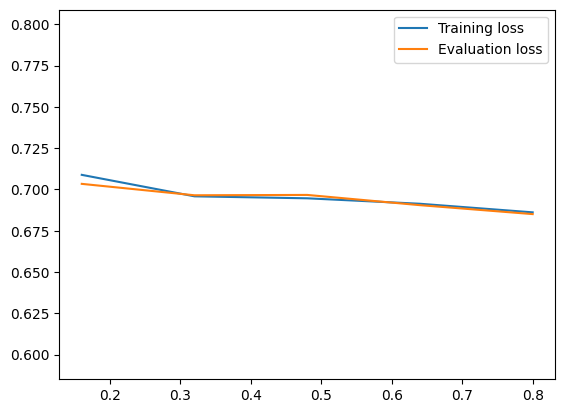

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot(logs, keys, labels):
    values = sum([logs[k] for k in keys], [])
    plt.ylim(max(min(values)-0.1, 0.0), min(max(values)+0.1, 1.0))
    for key, label in zip(keys, labels):
        plt.plot(logs["epoch"], logs[key], label=label)
    plt.legend()
    plt.show()

plot(training_logs.logs, ["loss", "eval_loss"], ["Training loss", "Evaluation loss"])

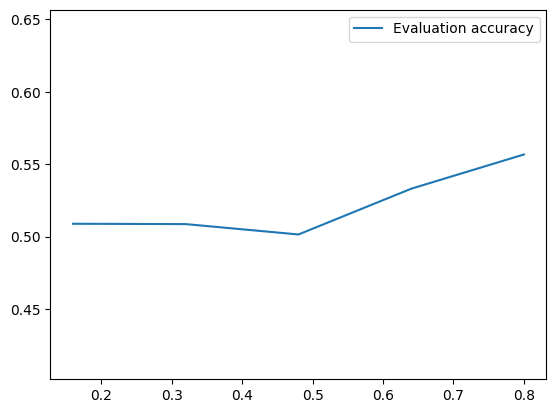

In [18]:
plot(training_logs.logs, ["eval_accuracy"], ["Evaluation accuracy"])

The model has barely learned anything. What's going on? Can you improve on the performance e.g. by modifying the hyperparameters?